Training Data Shape: (80000, 17)
Test Data Shape: (15996, 16)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    80000 non-null  int64  
 1   A       80000 non-null  float64
 2   B       80000 non-null  float64
 3   C       80000 non-null  float64
 4   D       80000 non-null  float64
 5   E       80000 non-null  float64
 6   F       80000 non-null  float64
 7   G       80000 non-null  float64
 8   H       80000 non-null  float64
 9   I       80000 non-null  float64
 10  J       80000 non-null  float64
 11  K       80000 non-null  float64
 12  L       80000 non-null  float64
 13  M       80000 non-null  float64
 14  N       80000 non-null  float64
 15  Y1      80000 non-null  float64
 16  Y2      80000 non-null  float64
dtypes: float64(16), int64(1)
memory usage: 10.4 MB

Missing Values in Training Data:
0


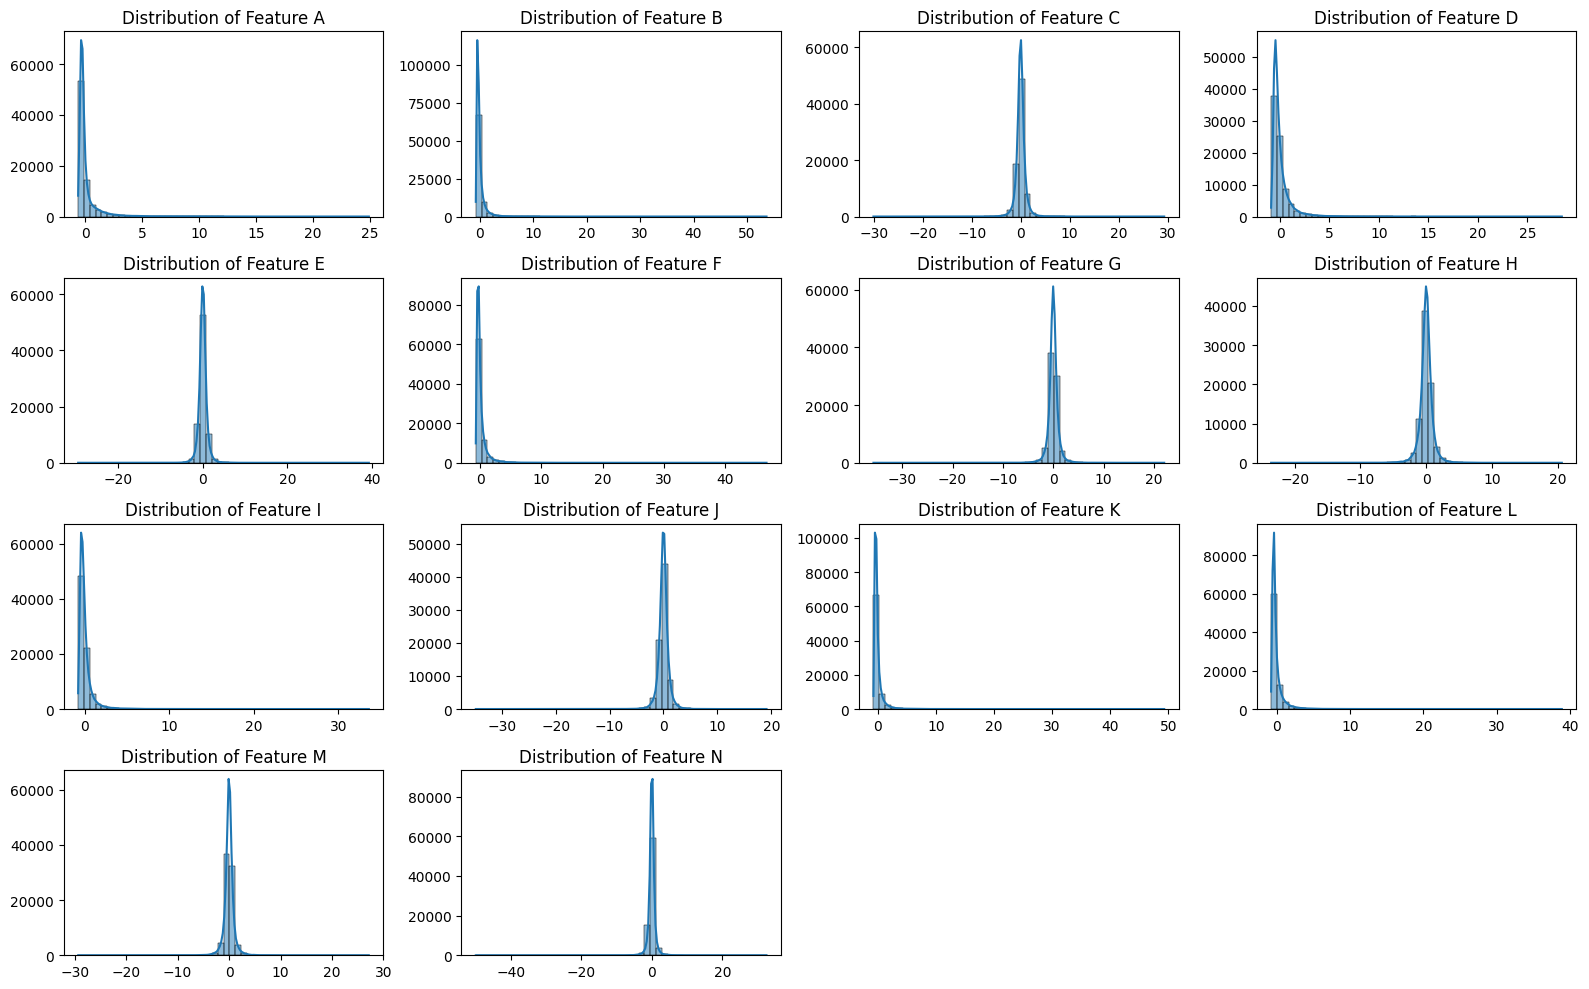

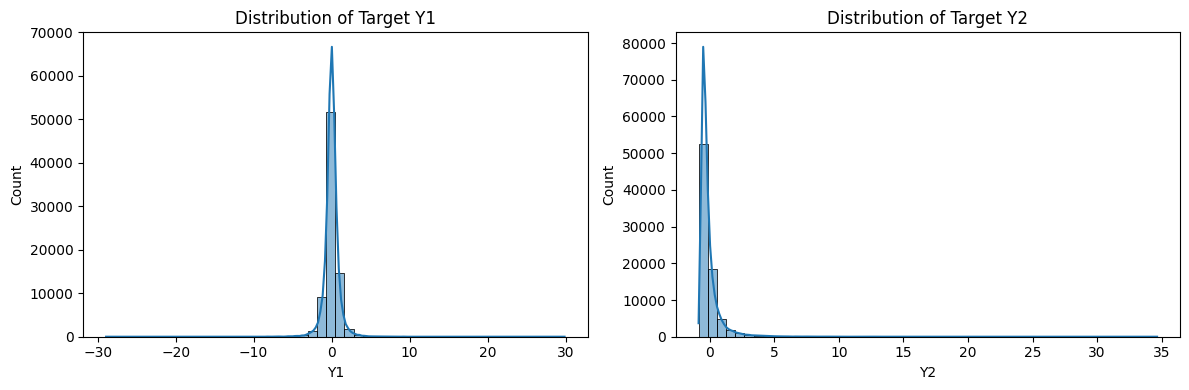

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')


print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

# --- Initial Analysis ---
print("\nTraining Data Info:")
train_df.info()

print("\nMissing Values in Training Data:")
print(train_df.isnull().sum().sum())

# --- Feature and Target Distribution Visualization ---
features = [col for col in train_df.columns if col not in ['time', 'Y1', 'Y2']]
targets = ['Y1', 'Y2']

plt.figure(figsize=(16, 10))
for i, col in enumerate(features):
    plt.subplot(4, 4, i + 1)
    sns.histplot(train_df[col], bins=50, kde=True)
    plt.title(f'Distribution of Feature {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i, col in enumerate(targets):
    plt.subplot(1, 2, i + 1)
    sns.histplot(train_df[col], bins=50, kde=True)
    plt.title(f'Distribution of Target {col}')
plt.tight_layout()
plt.show()

In [10]:
# --- Train/Holdout Split and Time-Based Subsetting ---
# We split the original training data into a main training set and a final holdout set.
# The holdout set is the most recent 20% of the data.
HOLDOUT_RATIO = 0.2
holdout_start_index = int(len(train_df) * (1 - HOLDOUT_RATIO))
train_main_df = train_df.iloc[:holdout_start_index].copy()
holdout_df = train_df.iloc[holdout_start_index:].reset_index(drop=True)


# From the main training set, we can select a percentage of the most recent data
# to train on. This is an adaptable hyperparameter.
TRAIN_SUBSET_RATIO = 0.7
subset_start_index = int(len(train_main_df) * (1 - TRAIN_SUBSET_RATIO))
train_subset_df = train_main_df.iloc[subset_start_index:].reset_index(drop=True)

print(f"Original training data length: {len(train_df)}")
print(f"Splitting into {int((1-HOLDOUT_RATIO)*100)}% training ({len(train_main_df)}) and {int(HOLDOUT_RATIO*100)}% holdout ({len(holdout_df)}).")
print(f"Using {TRAIN_SUBSET_RATIO*100}% of recent data from the main training set for training.")
print(f"New training data length: {len(train_subset_df)}")

Original training data length: 80000
Splitting into 80% training (64000) and 20% holdout (16000).
Using 70.0% of recent data from the main training set for training.
New training data length: 44800


In [11]:
# --- Cross-Sectional Feature Engineering ---
def create_cross_sectional_features(df, feature_cols):
    df_out = df.copy()
    df_out['feat_mean'] = df_out[feature_cols].mean(axis=1)
    df_out['feat_std'] = df_out[feature_cols].std(axis=1)
    df_out['feat_skew'] = df_out[feature_cols].skew(axis=1)
    df_out['feat_kurt'] = df_out[feature_cols].kurtosis(axis=1)
    df_out['feat_max'] = df_out[feature_cols].max(axis=1)
    df_out['feat_min'] = df_out[feature_cols].min(axis=1)
    return df_out

feature_cols = [f for f in train_subset_df.columns if f not in ['id', 'time', 'Y1', 'Y2']]
train_featured_df = create_cross_sectional_features(train_subset_df, feature_cols)

# Apply the same transformation to the test set
test_feature_cols = [f for f in test_df.columns if f not in ['id', 'time', 'Y1', 'Y2']]
test_featured_df = create_cross_sectional_features(test_df, test_feature_cols)

print("Columns after adding cross-sectional features:")
print(train_featured_df.columns)

Columns after adding cross-sectional features:
Index(['time', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'Y1', 'Y2', 'feat_mean', 'feat_std', 'feat_skew', 'feat_kurt',
       'feat_max', 'feat_min'],
      dtype='object')


In [14]:
train_for_concat = train_featured_df.drop(columns=['Y1', 'Y2'])
test_for_concat = test_featured_df.drop(columns=['id'])


# Concatenate, sort by time, and reset index to ensure proper rolling calculations
all_data = pd.concat([train_for_concat, test_for_concat], axis=0).sort_values('time').reset_index(drop=True)

# Define the features and window sizes for rolling statistics
original_features = [chr(ord('A') + i) for i in range(14)] # Creates a list ['A', 'B', ..., 'N']
windows = [100, 500, 1000] # Example window sizes from the text

for feat in original_features:
    for w in windows:
        # Calculate rolling mean
        all_data[f'{feat}_roll_mean_{w}'] = all_data[feat].rolling(window=w, min_periods=1).mean()
        # Calculate rolling standard deviation
        all_data[f'{feat}_roll_std_{w}'] = all_data[feat].rolling(window=w, min_periods=1).std()

# Impute NaNs that may result from std dev of a single element with 0
all_data.fillna(0, inplace=True)

# Split the data back into train and test sets using their original time values
train_final_df = all_data[all_data['time'].isin(train_featured_df['time'])].copy()
test_final_df = all_data[all_data['time'].isin(test_featured_df['time'])].copy()

# Re-attach the 'target' column to the training data using a merge
train_final_df = train_final_df.merge(train_featured_df[['time', 'Y1', 'Y2']], on='time')

# Re-attach the 'id' column to the test data using a merge
test_final_df = test_final_df.merge(test_featured_df[['time']], on='time')


print("Final training data shape with all features:", train_final_df.shape)
print("Final test data shape with all features:", test_final_df.shape)

Final training data shape with all features: (44800, 107)
Final test data shape with all features: (15996, 105)


In [15]:
import torch
import torch.nn as nn

class GRUModelV1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        """
        Initializes the 3-Layer GRU model.
        Args:
            input_size (int): The number of input features.
            hidden_size (int): The number of features in the hidden state.
            num_layers (int): The number of stacked GRU layers.
            output_size (int): The number of target variables to predict.
            dropout_rate (float): The dropout probability.
        """
        super(GRUModelV1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,  # Expects input shape (batch, seq, feature)
            dropout=dropout_rate if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Defines the forward pass of the model.
        Args:
            x (torch.Tensor): The input tensor of shape (batch, seq_len, input_size).
        """
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# --- Model Hyperparameters ---
INPUT_SIZE = train_final_df.shape[1] - 3 # Excluding time, Y1, Y2
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = 2
DROPOUT_RATE = 0.2

# Instantiate the model
model_v1 = GRUModelV1(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE)
print("Model V1 (3-Layer GRU) Architecture:")
print(model_v1)

Model V1 (3-Layer GRU) Architecture:
GRUModelV1(
  (gru): GRU(104, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


In [16]:
class GRUModelV2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        """
        Initializes the Hybrid GRU-MLP model.
        Args:
            input_size (int): The number of input features.
            hidden_size (int): The number of features in the GRU hidden state.
            output_size (int): The number of target variables to predict.
            dropout_rate (float): The dropout probability for the MLP part.
        """
        super(GRUModelV2, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1 # Single GRU layer

        self.gru = nn.GRU(
            input_size,
            hidden_size,
            self.num_layers,
            batch_first=True
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        """
        Defines the forward pass of the model.
        Args:
            x (torch.Tensor): The input tensor of shape (batch, seq_len, input_size).
        """
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Get the output of the last time step
        gru_out = out[:, -1, :]

        # Pass through the MLP
        final_out = self.mlp(gru_out)
        return final_out

# Instantiate the model
model_v2 = GRUModelV2(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, DROPOUT_RATE)
print("\nModel V2 (Hybrid GRU-MLP) Architecture:")
print(model_v2)


Model V2 (Hybrid GRU-MLP) Architecture:
GRUModelV2(
  (gru): GRU(104, 128, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [17]:
import torch.optim as optim

# Loss Function
# Minimizing MSE is equivalent to maximizing R-squared for a fixed dataset.
criterion = nn.MSELoss()

# Optimizer
# Adam is a robust choice for deep learning models.
# The learning rate is a critical hyperparameter.
LEARNING_RATE = 0.0005
optimizer_v1 = optim.Adam(model_v1.parameters(), lr=LEARNING_RATE)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=LEARNING_RATE)

print(f"\nLoss Function: {criterion}")
print(f"Optimizer: Adam with learning rate {LEARNING_RATE}")


Loss Function: MSELoss()
Optimizer: Adam with learning rate 0.0005


In [18]:
from sklearn.model_selection import TimeSeriesSplit

# --- Time-Series Cross-Validation Setup ---
# We will use TimeSeriesSplit to create the folds.
# Let's define a 3-fold split for demonstration.
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

X = train_final_df.drop(columns=['Y1', 'Y2', 'time'])
y = train_final_df[['Y1', 'Y2']]

print("Time-Series Cross-Validation Folds:")
for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}:")
    print(f"  Train: index from {train_index} to {train_index[-1]} (size: {len(train_index)})")
    print(f"  Validation: index from {val_index} to {val_index[-1]} (size: {len(val_index)})")

Time-Series Cross-Validation Folds:
Fold 1:
  Train: index from [    0     1     2 ... 11197 11198 11199] to 11199 (size: 11200)
  Validation: index from [11200 11201 11202 ... 22397 22398 22399] to 22399 (size: 11200)
Fold 2:
  Train: index from [    0     1     2 ... 22397 22398 22399] to 22399 (size: 22400)
  Validation: index from [22400 22401 22402 ... 33597 33598 33599] to 33599 (size: 11200)
Fold 3:
  Train: index from [    0     1     2 ... 33597 33598 33599] to 33599 (size: 33600)
  Validation: index from [33600 33601 33602 ... 44797 44798 44799] to 44799 (size: 11200)


In [19]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (
            self.X[idx : idx + self.sequence_length],
            self.y[idx + self.sequence_length - 1] # Target is at the end of the sequence
        )

# --- Hyperparameters for DataLoader ---
SEQUENCE_LENGTH = 50
BATCH_SIZE = 256

# Example for one fold
train_indices, val_indices = next(iter(tscv.split(X)))
X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

train_dataset = TimeSeriesDataset(X_train, y_train, SEQUENCE_LENGTH)
val_dataset = TimeSeriesDataset(X_val, y_val, SEQUENCE_LENGTH)

# Note: shuffle=False is critical for validation to preserve order for online learning simulation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Using sequence length: {SEQUENCE_LENGTH}")
print(f"Using batch size: {BATCH_SIZE}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Using sequence length: 50
Using batch size: 256
Number of training batches: 44
Number of validation batches: 44


In [20]:
# --- Conceptual Training Loop ---
from sklearn.metrics import r2_score

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for sequences, targets in dataloader:
        sequences, targets = sequences.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for sequences, targets in dataloader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())
            
    avg_loss = total_loss / len(dataloader)
    
    all_targets = np.concatenate(all_targets)
    all_predictions = np.concatenate(all_predictions)
    
    r2_y1 = r2_score(all_targets[:, 0], all_predictions[:, 0])
    r2_y2 = r2_score(all_targets[:, 1], all_predictions[:, 1])
    avg_r2 = (r2_y1 + r2_y2) / 2
    
    return avg_loss, avg_r2

# --- Main Training Execution (Conceptual) ---
# This would be run for each model and each CV fold.
NUM_EPOCHS = 20
best_val_r2 = -np.inf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v1.to(device)

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model_v1, train_loader, optimizer_v1, criterion, device)
    val_loss, val_r2 = evaluate(model_v1, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val R2: {val_r2:.4f}")
    
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        torch.save(model_v1.state_dict(), f'best_model_v1_fold1.pth')
        print(f"  -> New best model saved with R2: {best_val_r2:.4f}")

Epoch 1/20, Train Loss: 0.3431, Val Loss: 0.4274, Val R2: 0.2742
  -> New best model saved with R2: 0.2742
Epoch 2/20, Train Loss: 0.2088, Val Loss: 0.2740, Val R2: 0.5167
  -> New best model saved with R2: 0.5167
Epoch 2/20, Train Loss: 0.2088, Val Loss: 0.2740, Val R2: 0.5167
  -> New best model saved with R2: 0.5167
Epoch 3/20, Train Loss: 0.1566, Val Loss: 0.2422, Val R2: 0.5773
  -> New best model saved with R2: 0.5773
Epoch 3/20, Train Loss: 0.1566, Val Loss: 0.2422, Val R2: 0.5773
  -> New best model saved with R2: 0.5773
Epoch 4/20, Train Loss: 0.1370, Val Loss: 0.2312, Val R2: 0.5989
  -> New best model saved with R2: 0.5989
Epoch 4/20, Train Loss: 0.1370, Val Loss: 0.2312, Val R2: 0.5989
  -> New best model saved with R2: 0.5989
Epoch 5/20, Train Loss: 0.1274, Val Loss: 0.2352, Val R2: 0.5925
Epoch 5/20, Train Loss: 0.1274, Val Loss: 0.2352, Val R2: 0.5925
Epoch 6/20, Train Loss: 0.1172, Val Loss: 0.2272, Val R2: 0.6070
  -> New best model saved with R2: 0.6070
Epoch 6/20, Tr

KeyboardInterrupt: 

In [31]:
# New cell at end: Test set prediction and save
# This cell builds sequences from `test_final_df` using SEQUENCE_LENGTH,
# runs the trained `model_v1` (if a saved state dict exists it will load),
# and saves predictions for Y1 and Y2 to `test_preds_v1.csv`.
import os
import torch
from torch.utils.data import DataLoader

# Prepare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model_v1 exists in the namespace; if saved weights exist, load them
model_path = 'best_model_v1_fold1.pth'
if os.path.exists(model_path):
    try:
        model_v1.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded weights from {model_path}")
    except Exception as e:
        print(f"Could not load state dict: {e}")
else:
    print(f"Model weights not found at {model_path}. Using current `model_v1` in memory.")

model_v1.to(device)
model_v1.eval()

# Build test sequences
X_test = test_final_df.drop(columns=['time']).reset_index(drop=True)  # keep only features

# If test has fewer rows than SEQUENCE_LENGTH, handle gracefully
if len(X_test) < SEQUENCE_LENGTH:
    print(f"Test set shorter than SEQUENCE_LENGTH ({len(X_test)} < {SEQUENCE_LENGTH}). Expanding with zeros.")
    pad_needed = SEQUENCE_LENGTH - len(X_test)
    pad_df = pd.DataFrame(0, index=range(pad_needed), columns=X_test.columns)
    X_test = pd.concat([pad_df, X_test], axis=0).reset_index(drop=True)

# Create dataset-like sequences
sequences = []
indices = []  # store the original index corresponding to the sequence end
for i in range(len(X_test) - SEQUENCE_LENGTH + 1):
    seq = X_test.iloc[i : i + SEQUENCE_LENGTH].values.astype('float32')
    sequences.append(seq)
    indices.append(i + SEQUENCE_LENGTH - 1)

if len(sequences) == 0:
    raise ValueError("No sequences could be formed from the test set.")

sequences = torch.tensor(sequences, dtype=torch.float32)

# Use a dataloader for batching
test_loader = DataLoader(sequences, batch_size=BATCH_SIZE, shuffle=False)

all_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        preds = model_v1(batch)
        all_preds.append(preds.cpu().numpy())

all_preds = np.vstack(all_preds)

# Map predictions back to test rows. For sequences, predictions correspond to the end index stored in `indices`.
pred_df = pd.DataFrame(all_preds, columns=['Y1_pred', 'Y2_pred'])
# Attach time and id if present in original test_final_df (align by the end index)
end_rows = test_final_df.reset_index(drop=True).iloc[indices].copy()
result_df = pd.concat([end_rows[['time']].reset_index(drop=True), pred_df.reset_index(drop=True)], axis=1)

# Save to CSV
out_path = 'test_preds_v1.csv'
result_df.to_csv(out_path, index=False)
print(f"Saved {len(result_df)} predictions to {out_path}")

Loaded weights from best_model_v1_fold1.pth


/var/folders/rl/29fk2ndx1nzf2tjbxh8hbx840000gn/T/ipykernel_90599/1208465740.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


Saved 15947 predictions to test_preds_v1.csv


In [21]:
# New cell: Evaluate final model on holdout_df
# Prepares features, constructs sequences (pads if not enough history), runs model_v1,
# computes R2 for Y1/Y2, and saves results to 'holdout_preds_v1.csv'.
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load weights if available
model_path = 'best_model_v1_fold1.pth'
if os.path.exists(model_path):
    try:
        model_v1.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded weights from {model_path}")
    except Exception as e:
        print(f"Could not load state dict: {e}")
else:
    print(f"Model weights not found at {model_path}. Using current `model_v1` in memory.")

model_v1.to(device)
model_v1.eval()

# Ensure helper function exists; if not, create a minimal version
try:
    create_cross_sectional_features
except NameError:
    def create_cross_sectional_features(df, feature_cols):
        df_out = df.copy()
        df_out['feat_mean'] = df_out[feature_cols].mean(axis=1)
        df_out['feat_std'] = df_out[feature_cols].std(axis=1)
        df_out['feat_skew'] = df_out[feature_cols].skew(axis=1)
        df_out['feat_kurt'] = df_out[feature_cols].kurtosis(axis=1)
        df_out['feat_max'] = df_out[feature_cols].max(axis=1)
        df_out['feat_min'] = df_out[feature_cols].min(axis=1)
        return df_out

# Get SEQUENCE_LENGTH and BATCH_SIZE from namespace or set defaults
try:
    SEQ_LEN = SEQUENCE_LENGTH
except NameError:
    SEQ_LEN = 50
    print(f"SEQUENCE_LENGTH not found, defaulting to {SEQ_LEN}")
try:
    BS = BATCH_SIZE
except NameError:
    BS = 256
    print(f"BATCH_SIZE not found, defaulting to {BS}")

# Build featured holdout dataframe
feature_cols = [c for c in holdout_df.columns if c not in ['time','Y1','Y2']]
holdout_featured_df = create_cross_sectional_features(holdout_df, feature_cols)

# Determine base dataframe to compute rolling stats so sequences have history.
# Prefer using the already-constructed train_featured_df if present.
if 'train_featured_df' in globals():
    train_for_roll = train_featured_df.drop(columns=['Y1','Y2'], errors='ignore')
else:
    # fall back to using train_main_df (raw) and create featured version
    if 'train_main_df' in globals():
        tf = train_main_df.copy()
        cols = [c for c in tf.columns if c not in ['time','Y1','Y2']]
        train_for_roll = create_cross_sectional_features(tf, cols).drop(columns=['Y1','Y2'], errors='ignore')
    else:
        train_for_roll = pd.DataFrame()

# Concatenate train history (if any) with holdout for rolling calculations
base_for_roll = pd.concat([train_for_roll, holdout_featured_df.drop(columns=['Y1','Y2'], errors='ignore')], axis=0)
base_for_roll = base_for_roll.sort_values('time').reset_index(drop=True)

# Define original feature columns to compute rolling stats on (A..N found in base)
possible_feats = [chr(ord('A') + i) for i in range(14)]
original_features = [f for f in possible_feats if f in base_for_roll.columns]
if len(original_features) == 0:
    # fallback: pick first 14 non-meta columns
    original_features = [c for c in base_for_roll.columns if c not in ['time','id','Y1','Y2']][:14]

windows = [100, 500, 1000]
for feat in original_features:
    for w in windows:
        base_for_roll[f'{feat}_roll_mean_{w}'] = base_for_roll[feat].rolling(window=w, min_periods=1).mean()
        base_for_roll[f'{feat}_roll_std_{w}'] = base_for_roll[feat].rolling(window=w, min_periods=1).std().fillna(0)

base_for_roll.fillna(0, inplace=True)

# Extract holdout rows from base_for_roll by matching times
hold_times = holdout_featured_df['time'].tolist()
holdout_rows_idx = base_for_roll[base_for_roll['time'].isin(hold_times)].index.tolist()
holdout_final_df = base_for_roll.loc[holdout_rows_idx].reset_index(drop=True)
# Attach true targets from holdout_featured_df
holdout_final_df = holdout_final_df.merge(holdout_featured_df[['time','Y1','Y2']], on='time')

# Prepare feature column ordering (exclude meta columns)
model_input_cols = [c for c in holdout_final_df.columns if c not in ['time','Y1','Y2']]

# Build sequences for each holdout row, padding at the top if necessary
sequences = []
true_targets = []
times_list = []
for idx, row_idx in enumerate(holdout_final_df.index):
    end_idx = holdout_rows_idx[idx]
    start_idx = end_idx - SEQ_LEN + 1
    if start_idx < 0:
        # need to pad
        needed = SEQ_LEN - (end_idx + 1)
        pad = np.zeros((needed, len(model_input_cols)), dtype=np.float32)
        seq_part = base_for_roll.loc[0:end_idx, model_input_cols].values.astype(np.float32)
        seq = np.vstack([pad, seq_part])
    else:
        seq = base_for_roll.loc[start_idx:end_idx, model_input_cols].values.astype(np.float32)
    sequences.append(seq)
    true_targets.append(holdout_final_df.loc[idx, ['Y1','Y2']].values.astype(np.float32))
    times_list.append(holdout_final_df.loc[idx, 'time'])

sequences = np.stack(sequences)
true_targets = np.vstack(true_targets)

# Run inference in batches
from torch.utils.data import DataLoader, TensorDataset
seq_tensor = torch.tensor(sequences, dtype=torch.float32)
loader = DataLoader(seq_tensor, batch_size=BS, shuffle=False)
all_preds = []
with torch.no_grad():
    for b in loader:
        b = b.to(device)
        preds = model_v1(b)
        all_preds.append(preds.cpu().numpy())
all_preds = np.vstack(all_preds)

# Compute R2
r2_y1 = r2_score(true_targets[:,0], all_preds[:,0])
r2_y2 = r2_score(true_targets[:,1], all_preds[:,1])
avg_r2 = (r2_y1 + r2_y2) / 2
print(f"Holdout R2 Y1: {r2_y1:.4f}, Y2: {r2_y2:.4f}, Avg: {avg_r2:.4f}")

# Save results
out_df = pd.DataFrame({
    'time': times_list,
    'Y1_true': true_targets[:,0],
    'Y2_true': true_targets[:,1],
    'Y1_pred': all_preds[:,0],
    'Y2_pred': all_preds[:,1]
})
out_df.to_csv('holdout_preds_v1.csv', index=False)
print(f"Saved {len(out_df)} holdout predictions to 'holdout_preds_v1.csv'")

Loaded weights from best_model_v1_fold1.pth
Holdout R2 Y1: 0.5957, Y2: 0.4489, Avg: 0.5223
Saved 16000 holdout predictions to 'holdout_preds_v1.csv'
Holdout R2 Y1: 0.5957, Y2: 0.4489, Avg: 0.5223
Saved 16000 holdout predictions to 'holdout_preds_v1.csv'
